In [121]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve

Local Polynomial Approximation
-------------------------------
Set the parameters

In [122]:
# maximum degree of polynomial used for fitting
# N = 2

# filter size
# M = 51

# large M, small N -> a lot of bias when frequency increases
# N = 2
# M = 51

# large M, large N -> smaller bias than before, but a lot of variance in smooth regions
N = 7
M = 51

# small M, small N -> smaller bias everywhere, higher variance
# N = 2
# M = 5

# M small, M = N,  -> smaller bias than before, higher variance than before
# N = 5
# N = M

Generate synthetic signal signal

In [123]:
LENGHT = 1000

ty = np.linspace(0, 1, LENGHT)
y = np.sin(2 / (ty + 0.05))

#  noise standard deviation
sigma = 0.1

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)


Text(0.5, 1.0, 'Input Signal')

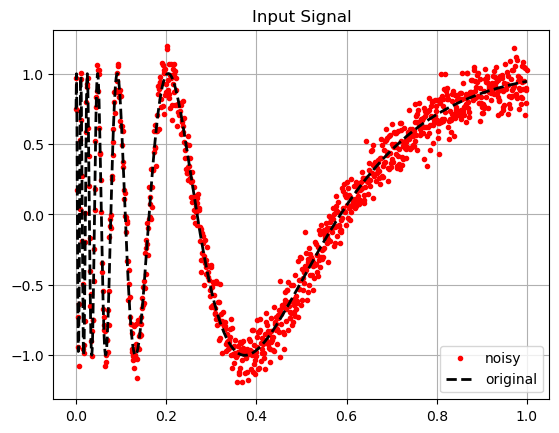

In [124]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window


In [125]:
t = np.linspace(-1, 1, M)
T = np.vander(t, N+1, increasing=True)


Look at the matrix T, the columns correspond to polynomials sampled over the interval [0,1]


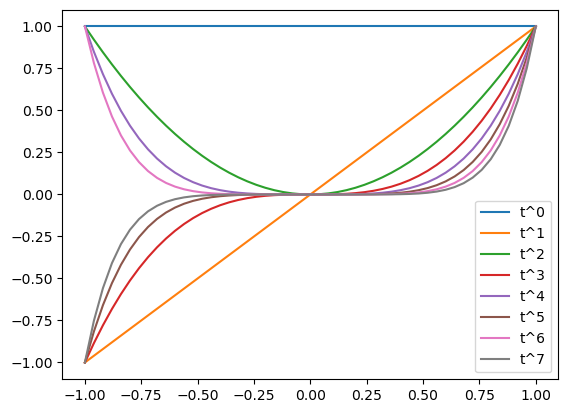

In [126]:
plt.figure()
leg = []
for l in range(N+1):
    plt.plot(t, T[:, l])
    leg.append(f't^{l:d}')
plt.legend(leg)

Construct the LPA kernel

In [127]:
# comput the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(T)

# select the central row of W2Qtilde
row = Q[M//2, :]

# compute the kernel
g = row @ Q.T

# flipping, since it is used in convolution
g = np.flip(g)

Text(0.5, 1.0, 'M = 51, N = 7')

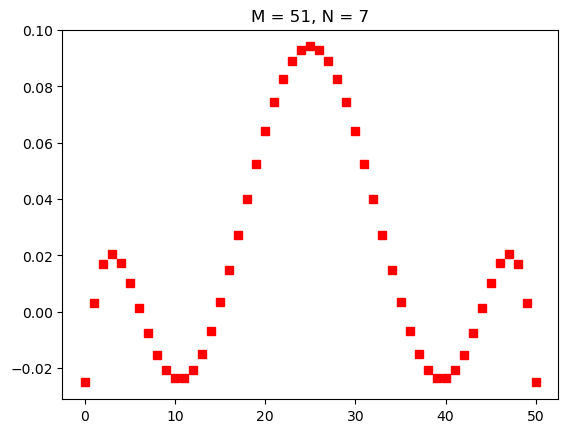

In [128]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'M = {M:d}, N = {N:d}')


Filtering

In [129]:
shat = convolve(s, g, mode='same')

Text(0.5, 1.0, 'M = 51, N = 7')

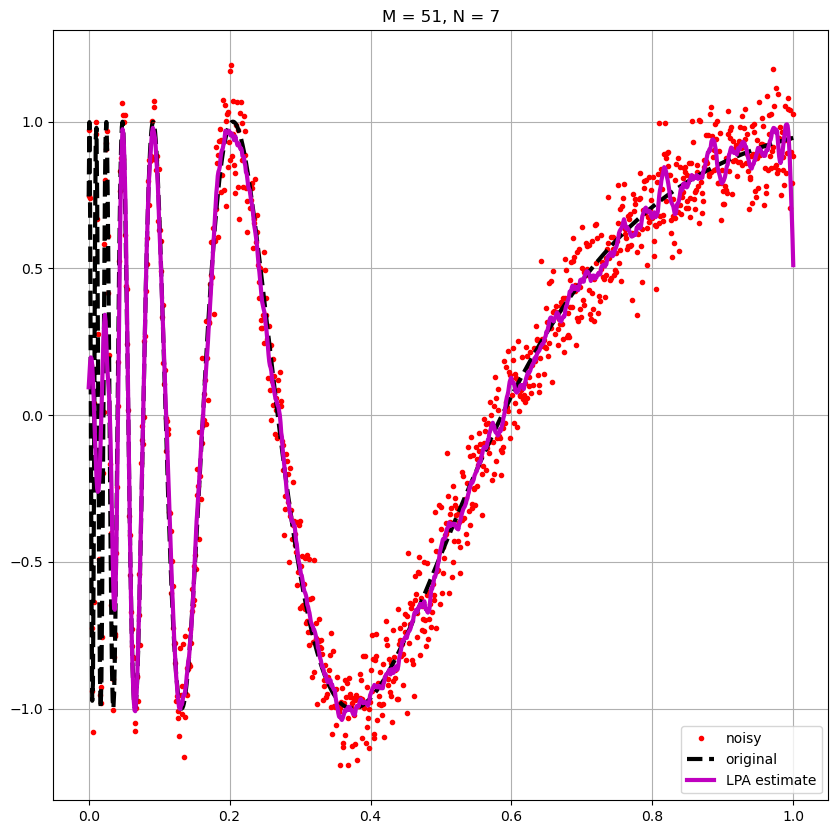

In [130]:
plt.figure(figsize=(10,10))
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')


Weighted LPA
--------------
Set the parameters

In [177]:
# maximum degree of polynomial used for fitting
N = 2

# filter size
M = 53

# half filter size
HFS = int((M-1)/2)

# set the weights. Here weights simply define the window size
w = np.zeros(M)

# centered kernel
wc = w.copy()
wc[int(HFS/2):-int(HFS/2)] = 1

# left kernel
wl = w.copy()
wl[:HFS+1] = 1

# right kernel
wr = w.copy()
wr[-HFS-1:] = 1


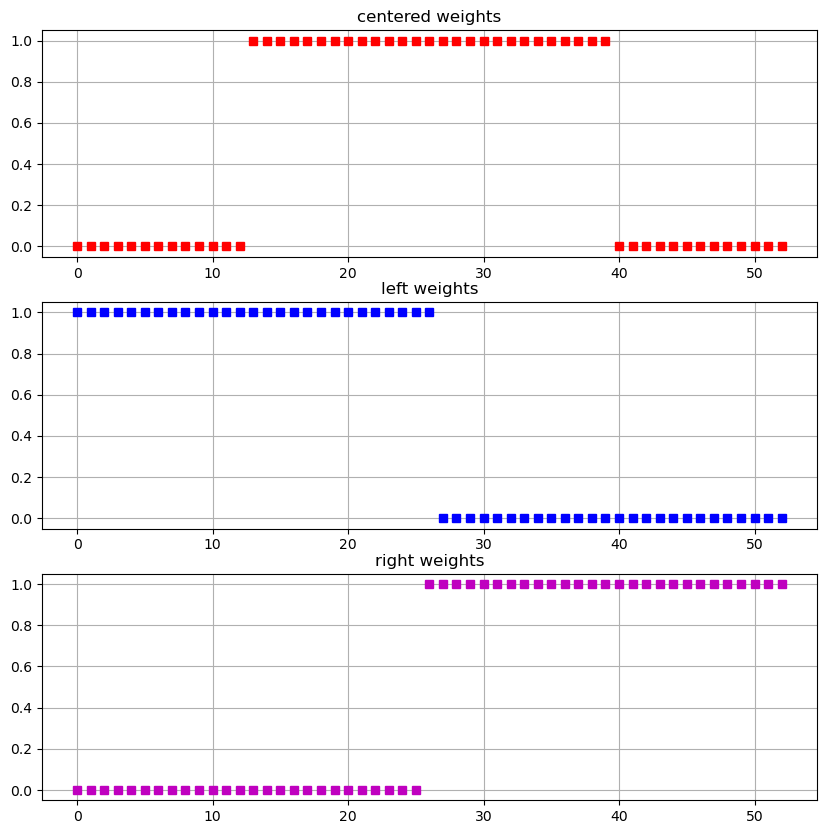

In [178]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(wc, 'rs', linewidth=3)
ax[0].set_title('centered weights')
ax[0].grid()
ax[1].plot(wl, 'bs', linewidth=3)
ax[1].set_title('left weights')
ax[1].grid()
ax[2].plot(wr, 'ms', linewidth=3)
ax[2].set_title('right weights')
ax[2].grid()


Build the weight matrix

In [179]:
# select a single weight to be used in what follows
w = wc

# generate the inverse of weights
winv = 1/w

# set to zero weights that are inf
winv[np.isinf(winv)] = 0

# define the weight matrix
W = np.diag(w)
Winv = np.diag(winv)

C:\Users\chech\AppData\Local\Temp\ipykernel_27596\2994986781.py:5: RuntimeWarning: divide by zero encountered in true_divide
  winv = 1/w


Generate synthetic signal signal

In [180]:
LENGHT = 1000

# clean signal
ty = np.linspace(0, 1, LENGHT)
y =  8*ty**2 - 2*ty + 2
y[LENGHT//2 : LENGHT] = y[LENGHT//2 : LENGHT] + 7

#  noise standard deviation
sigma = 0.2

# noisy signal
s = y + sigma*np.random.normal(size=LENGHT)

Text(0.5, 1.0, 'Input Signal')

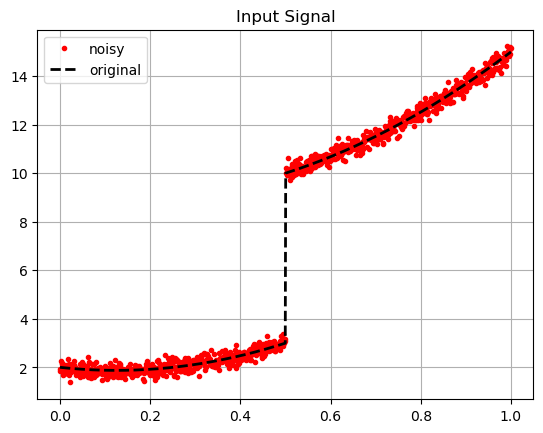

In [181]:

plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=2)
plt.grid()
plt.legend(['noisy', 'original'])
plt.title('Input Signal')

Define the matrix T containing the polynomials sampled over the window

In [182]:
t = np.linspace(-1, 1, M) 
T = np.vander(t, N+1, increasing=True)


Construct the LPA kernel

In [183]:
# compute the qr decomposition of WT
# since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
Q, R = np.linalg.qr(W@T)

#  define Qtilde
Qtilde = Winv @ Q

# adjust Qtilde with the  weights matrix squared.
W2Qtilde = W**2 @ Qtilde

# select the central row of W2Qtilde
row = W2Qtilde[W2Qtilde.shape[0]//2, :] 

# compute the kernel
g = row @ W2Qtilde.T

# flipping, since it is used in convolution
g = np.flip(g)


Text(0.5, 1.0, 'filter M = 53, N = 2')

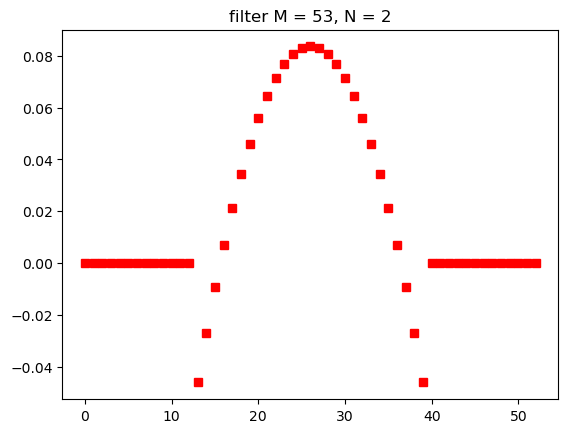

In [184]:
plt.figure()
plt.plot(g, 'rs', linewidth=3)
plt.title(f'filter M = {M:d}, N = {N:d}')


Filtering


In [185]:
shat =  convolve(s, g, mode="same")


Text(0.5, 1.0, 'M = 53, N = 2')

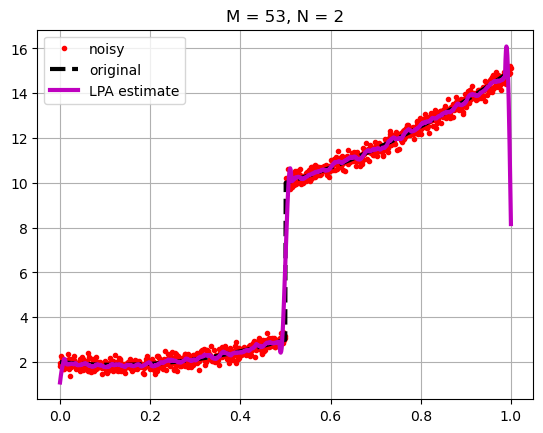

In [186]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, shat, 'm-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA estimate'])
plt.title(f'M = {M:d}, N = {N:d}')



Modify the code to use the central, left and right kernels

### Function for a general LPA

In [187]:
def weightedLPA(polyDegree, filterSize, weightsKernel, Signal):
    # select a single weight to be used in what follows
    w = weightsKernel

    # generate the inverse of weights
    winv = 1/w

    # set to zero weights that are inf
    winv[np.isinf(winv)] = 0

    # define the weight matrix
    W = np.diag(w)
    Winv = np.diag(winv)

    #Defining matrix T
    t = np.linspace(-1, 1, M) 
    T = np.vander(t, N+1, increasing=True)

    # compute the qr decomposition of WT
    # since T has more rows than columns, then qr computes only the first N + 1 columns of Q and the first N + 1 rows of R.
    Q, R = np.linalg.qr(W@T)

    #  define Qtilde
    Qtilde = Winv @ Q

    # adjust Qtilde with the  weights matrix squared.
    W2Qtilde = W**2 @ Qtilde

    # select the central row of W2Qtilde
    row = W2Qtilde[W2Qtilde.shape[0]//2, :] 

    # compute the kernel
    g = row @ W2Qtilde.T

    # flipping, since it is used in convolution
    g = np.flip(g)

    return convolve(s, g, mode="same")


In [188]:
rightAprox = weightedLPA(N, M, wr, s)

C:\Users\chech\AppData\Local\Temp\ipykernel_27596\568511044.py:6: RuntimeWarning: divide by zero encountered in true_divide
  winv = 1/w


In [189]:
leftAprox = weightedLPA(N, M, wl, s)

C:\Users\chech\AppData\Local\Temp\ipykernel_27596\568511044.py:6: RuntimeWarning: divide by zero encountered in true_divide
  winv = 1/w


Text(0.5, 1.0, 'M = 53, N = 2')

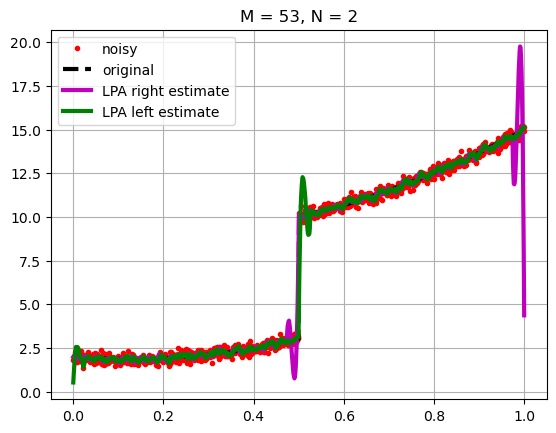

In [190]:
plt.figure()
plt.plot(ty, s, 'r.')
plt.plot(ty, y, 'k--', linewidth=3)
plt.plot(ty, rightAprox, 'm-', linewidth=3)
plt.plot(ty, leftAprox, 'g-', linewidth=3)
plt.grid()
plt.legend(['noisy', 'original', 'LPA right estimate', 'LPA left estimate'])
plt.title(f'M = {M:d}, N = {N:d}')
